In [1]:
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.

True

In [2]:
from langchain_core.tools import BaseTool


class CustomSearch(BaseTool):
    """Tool that queries the CustomSearch."""

    name: str = "custom_search"
    description: str = (
        "a search engine. "
        "useful for when you need to answer questions about current events."
        " input should be a search query."
    )

    def _run(
        self,
        query: str,
    ) -> str:
        """Use the tool."""
        return f"custom_search_wrapper.run({query})"


In [3]:
tool = CustomSearch()
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

"custom_search_wrapper.run(What's a 'node' in LangGraph?)"

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from typing import Final

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


NODE_CHATBOT: Final = "chatbot"
graph_builder.add_node(NODE_CHATBOT, chatbot)

In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
NODE_TOOLS: Final = "tools"
graph_builder.add_node(NODE_TOOLS, tool_node)

In [6]:
from typing import Literal
from langgraph.graph import END, START


def route_tools(
    state: State,
) -> Literal[NODE_TOOLS, END]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return NODE_TOOLS
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {NODE_TOOLS: NODE_TOOLS, END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge(NODE_TOOLS, NODE_CHATBOT)
graph_builder.add_edge(START, NODE_CHATBOT)
graph = graph_builder.compile()

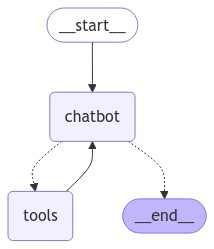

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

Assistant: 你好！有什么我可以帮助你的吗？
Assistant: 
Assistant: "custom_search_wrapper.run(\u4eca\u5929\u5929\u6c14)"
Assistant: 
Assistant: "custom_search_wrapper.run(\u4eca\u5929\u5929\u6c14\u9884\u62a5)"
Assistant: 请提供您所在的城市或地区，以便我为您查询具体的天气情况。
Assistant: 
Assistant: "custom_search_wrapper.run(\u5e7f\u5dde)"
Assistant: 
Assistant: "custom_search_wrapper.run(Guangzhou)"
Assistant: 广州（Guangzhou）是中国广东省的省会，位于珠江三角洲地区，是中国南方的重要城市之一。广州以其丰富的历史、文化和经济发展而闻名，是中国的商业和贸易中心之一。

广州的主要特点包括：

1. **经济中心**：广州是中国的经济重心之一，拥有众多的企业和工业园区，是国际贸易的重要港口城市。

2. **文化多样性**：广州有着悠久的历史和丰富的文化，融合了多种文化元素，包括粤文化、华南文化等。

3. **美食之都**：广州以其独特的粤菜而闻名，尤其是早茶和海鲜，吸引了众多游客前来品尝。

4. **旅游景点**：广州有许多著名的旅游景点，如广州塔、白云山、陈家祠等，吸引了大量游客。

5. **交通便利**：广州的交通网络发达，包括地铁、公交、火车和机场，方便游客和居民出行。

如果你对广州有特定的方面感兴趣，比如旅游、文化、经济等，请告诉我，我可以提供更详细的信息。
Goodbye!
